<a href="https://colab.research.google.com/github/nelsonalbertohj/Magno-Parvo-CNN/blob/main/Data_analysis_and_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Analysis and Results

In [ ]:
!pip install tensorflow_addons

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd

import keras
import time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Average
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef
import seaborn as sn
import matplotlib.colors as colors
from scipy.stats import binom

print("Tensorflow version: ",tf.__version__)
%matplotlib qt

Tensorflow version:  2.6.0


ImportError: Failed to import any qt binding

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Loading Testing Sets and Models

In [9]:
root = "C:/Users/nelso/My Drive (nelsonh@mit.edu)/Vision Dataset"
N_CLASSES = 10
loc = root + f"/Imagenet-{N_CLASSES}-1500-splits/test"
data_dir = pathlib.Path(loc)

occlude_loc = root + f"/Imagenet-{N_CLASSES}-1500-splits/test_occluded"
occlude_dir = pathlib.Path(occlude_loc)

batch_size = 32
img_height = 224
img_width = 224

#Testing set
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_occlude_ds = tf.keras.utils.image_dataset_from_directory(
  occlude_dir,
  seed=123,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1297 files belonging to 10 classes.
Found 1296 files belonging to 10 classes.


In [10]:
def img_transforms(data,label): #The vanilla testing set
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

def blurr_img_transforms(data,label): #The blurred testing set
    data = tfa.image.gaussian_filter2d(data,filter_shape=(10,10),sigma=5.0)
    normalize_img = tf.keras.layers.Rescaling(1./255)
    color_norm = normalize_img(data)
    gray_img = tf.image.rgb_to_grayscale(data)
    gray_norm_img = normalize_img(gray_img)
    gray_norm_img = tfa.image.gaussian_filter2d(gray_norm_img,filter_shape=(10,10),sigma=5.0)
    concat_img = tf.concat([color_norm, gray_norm_img],axis=-1)
    return concat_img,label

AUTOTUNE = tf.data.AUTOTUNE
test_ds_vanilla = test_ds.map(img_transforms)
test_ds_blurred = test_ds.map(blurr_img_transforms)
test_ds_occluded = test_occlude_ds.map(img_transforms)

CASHE_Test_vanilla = root + f"/Imagenet-{N_CLASSES}-1500-splits/CASHE_Test_{N_CLASSES}_1500"
test_ds_vanilla = test_ds_vanilla.cache(CASHE_Test_vanilla).prefetch(buffer_size=AUTOTUNE)

CASHE_Test_blurred = root + f"/Imagenet-{N_CLASSES}-1500-splits/CASHE_Test_Dist_Blur_{N_CLASSES}_1500"
test_ds_blurred = test_ds_blurred.cache(CASHE_Test_blurred).prefetch(buffer_size=AUTOTUNE)

CASHE_Test_occlude = root + f"/Imagenet-{N_CLASSES}-1500-splits/CASHE_Test_Dist_Occlude_{N_CLASSES}_1500"
test_ds_occluded = test_ds_occluded.cache(CASHE_Test_occlude).prefetch(buffer_size=AUTOTUNE)

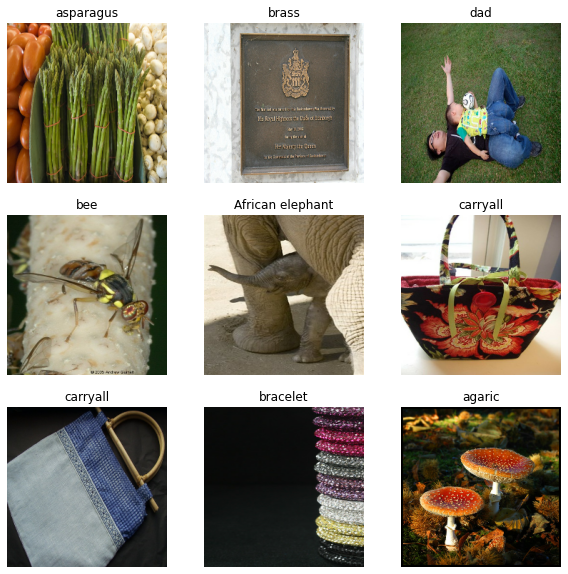

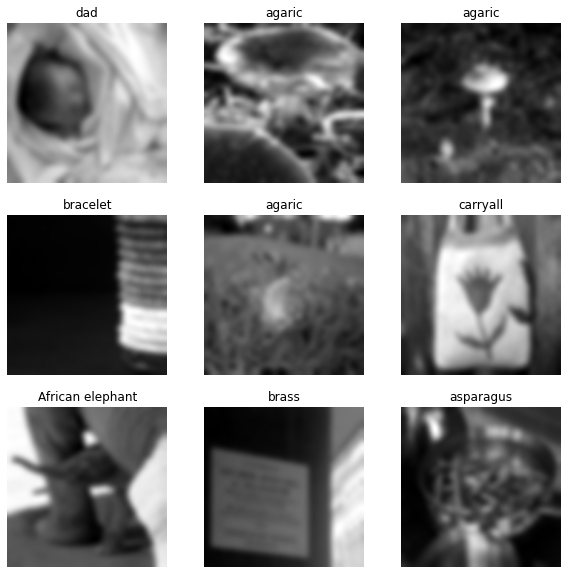

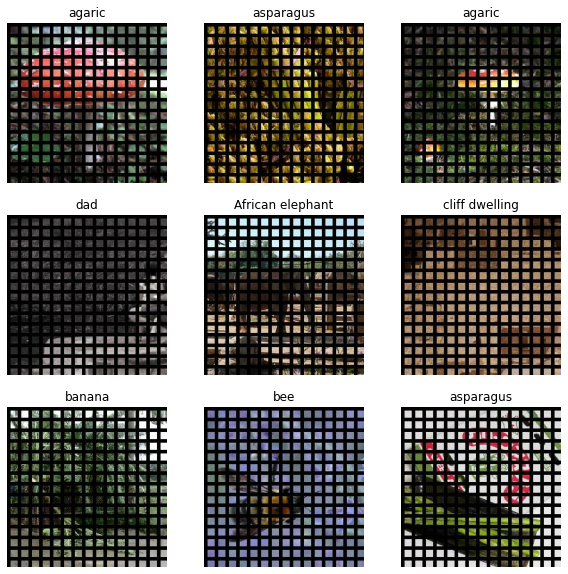

In [41]:
class_names = test_ds.class_names
gray_imgs = []
plt.figure(figsize=(10, 10))
for images, labels in test_ds_vanilla.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,:-1])
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in test_ds_blurred.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,-1],cmap="gray")
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in test_ds_occluded.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        current_img = images[i]
        plt.imshow(current_img.numpy()[:,:,:-1])
        gray_imgs.append((current_img,np.argmax(labels[i])))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [14]:
# Used to create CASHE in local disk by loading all images
idx = 0
start_time = time.time()
for t in test_ds_vanilla:
  print("time to get object: ", time.time()-start_time)
  idx += 1
  start_time = time.time()

time to get object:  2.1414802074432373
time to get object:  0.1290290355682373
time to get object:  0.061014652252197266
time to get object:  0.05601692199707031
time to get object:  0.05801200866699219
time to get object:  0.05200815200805664
time to get object:  0.06101369857788086
time to get object:  0.054010629653930664
time to get object:  0.05301094055175781
time to get object:  0.05801582336425781
time to get object:  0.05400824546813965
time to get object:  0.0490117073059082
time to get object:  0.06201338768005371
time to get object:  0.06801557540893555
time to get object:  0.051011085510253906
time to get object:  0.06201362609863281
time to get object:  1.082242488861084
time to get object:  0.049012184143066406
time to get object:  0.058011770248413086
time to get object:  0.04801130294799805
time to get object:  0.05201292037963867
time to get object:  0.05701255798339844
time to get object:  0.12502670288085938
time to get object:  0.05601310729980469
time to get obje

In [16]:
dual_stream_model = tf.keras.models.load_model(root + f"/Models/Early_Testing_Models/FullRes_with_CNN_1000_Samples_{N_CLASSES}Classes")
single_model = tf.keras.models.load_model(root + f"/Models/Early_Testing_Models/Dualstream_with_CNN_1000_Samples_{N_CLASSES}Classes")

### Testing the Vanilla Testing Set

In [19]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_vanilla)

single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_vanilla)

41/41 [==============================] - 2s 45ms/step - loss: 1.1965 - accuracy: 0.7826


In [20]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_vanilla)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_vanilla)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_vanilla])
true_outputs = np.argmax(true_outputs,axis=1)

In [21]:
print(classification_report(true_outputs,dual_pred_outputs))
print(matthews_corrcoef(true_outputs, dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82       140
           1       0.97      0.91      0.93       127
           2       0.63      0.79      0.70       135
           3       0.71      0.82      0.76       125
           4       0.75      0.70      0.73       125
           5       0.67      0.78      0.72       128
           6       0.77      0.84      0.80       139
           7       0.78      0.57      0.66       127
           8       0.79      0.94      0.86       127
           9       0.82      0.60      0.69       124

    accuracy                           0.77      1297
   macro avg       0.78      0.77      0.77      1297
weighted avg       0.78      0.77      0.77      1297

0.7460387968527745


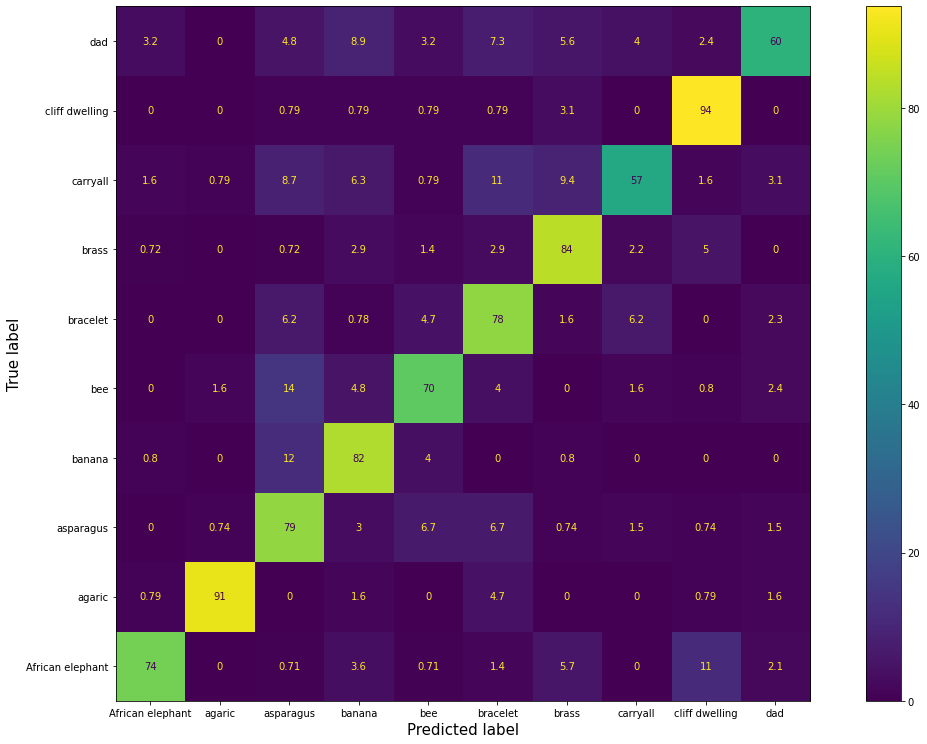

In [25]:
#Generate Confusion Matrix for Dual-stream model
A = confusion_matrix(true_outputs,dual_pred_outputs)
cm_dual_vanilla = confusion_matrix(true_outputs,dual_pred_outputs,normalize='true') * 100
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm_dual_vanilla,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
ax.invert_yaxis()

In [23]:
print(classification_report(true_outputs,single_pred_outputs))
print(matthews_corrcoef(true_outputs, single_pred_outputs))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       140
           1       0.92      0.87      0.89       127
           2       0.75      0.83      0.79       135
           3       0.66      0.86      0.75       125
           4       0.70      0.80      0.75       125
           5       0.75      0.70      0.73       128
           6       0.85      0.85      0.85       139
           7       0.82      0.57      0.67       127
           8       0.88      0.83      0.85       127
           9       0.70      0.73      0.71       124

    accuracy                           0.78      1297
   macro avg       0.79      0.78      0.78      1297
weighted avg       0.79      0.78      0.78      1297

0.759303661432496


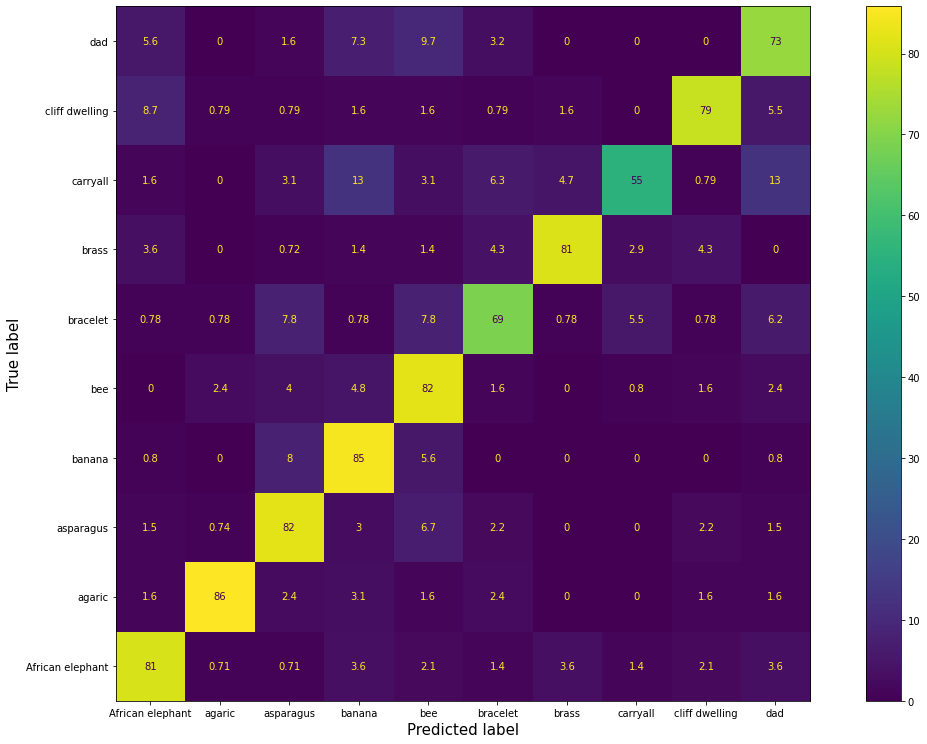

In [ ]:
#Generate Confusion Matrix for Single-stream ResNet
cm_single_vanilla = confusion_matrix(true_outputs,single_pred_outputs, normalize='true') * 100
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm_single_vanilla,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
ax.invert_yaxis()

'\ndisp_cm = ConfusionMatrixDisplay(cm_diff_vanilla,display_labels=class_names)\n\nax.set_xlabel("Predicted Label", fontsize = 15)\nax.set_ylabel("True Label", fontsize = 15)\n\nplt.tight_layout()\n\ndisp_cm.plot(ax=ax)\ndisp_cm.ax_.invert_yaxis()\n\nim = disp_cm.im_\n\n#plt.set_cmap(\'bwr\')'

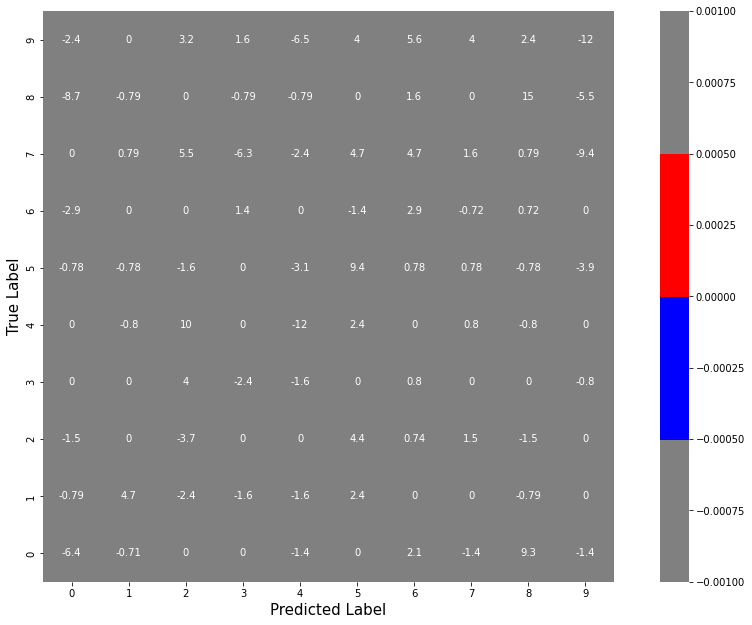

In [ ]:
# Confusion Difference Matrix (Dual minus Single)

# Test if Single (B) is draw from a differnt distrbution that Dual (A)

cm_diff_vanilla = cm_dual_vanilla - cm_single_vanilla

B = confusion_matrix(true_outputs,single_pred_outputs)
n_trials = np.sum(B, axis=1)
p = confusion_matrix(true_outputs,single_pred_outputs, normalize='true')
m = np.copy(B)
C = np.zeros(shape=(10,10))
for row in range(10):
    n = n_trials[row]
    for col in range(10):
        dist = binom(n,p[row, col])
        if cm_diff_vanilla[row,col] >= 0:
            sign = 1
        else:
            sign = -1
        C[row,col] = dist.pmf(B[row,col]) * sign

cmap = colors.ListedColormap(["gray", "blue", "red", "gray"])
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-3, vmin=-1e-3, square=True, annot=cm_diff_vanilla, cmap=cmap)
#ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-1, vmin=-1e-1, annot=cm_diff_vanilla, cmap='bwr')
#ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-1, vmin=-1e-1, annot=cm_diff_vanilla, cmap=cmap)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
ax.invert_yaxis()



'''
disp_cm = ConfusionMatrixDisplay(cm_diff_vanilla,display_labels=class_names)

ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
disp_cm.ax_.invert_yaxis()

im = disp_cm.im_

#plt.set_cmap('bwr')'''

### Testing the Blurred condition

In [ ]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_blurred)

single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_blurred)

41/41 [==============================] - 2s 44ms/step - loss: 2.5524 - accuracy: 0.5436


In [ ]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_blurred)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_blurred)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_blurred])
true_outputs = np.argmax(true_outputs,axis=1)

In [ ]:
print(classification_report(true_outputs,dual_pred_outputs))
print(matthews_corrcoef(true_outputs, dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.87      0.44      0.58       140
           1       0.97      0.77      0.86       127
           2       0.39      0.88      0.54       135
           3       0.66      0.60      0.63       125
           4       0.63      0.70      0.66       125
           5       0.51      0.70      0.59       128
           6       0.88      0.68      0.76       139
           7       0.85      0.31      0.46       127
           8       0.79      0.72      0.75       127
           9       0.59      0.60      0.60       124

    accuracy                           0.64      1297
   macro avg       0.71      0.64      0.64      1297
weighted avg       0.72      0.64      0.64      1297

0.6077948055109794


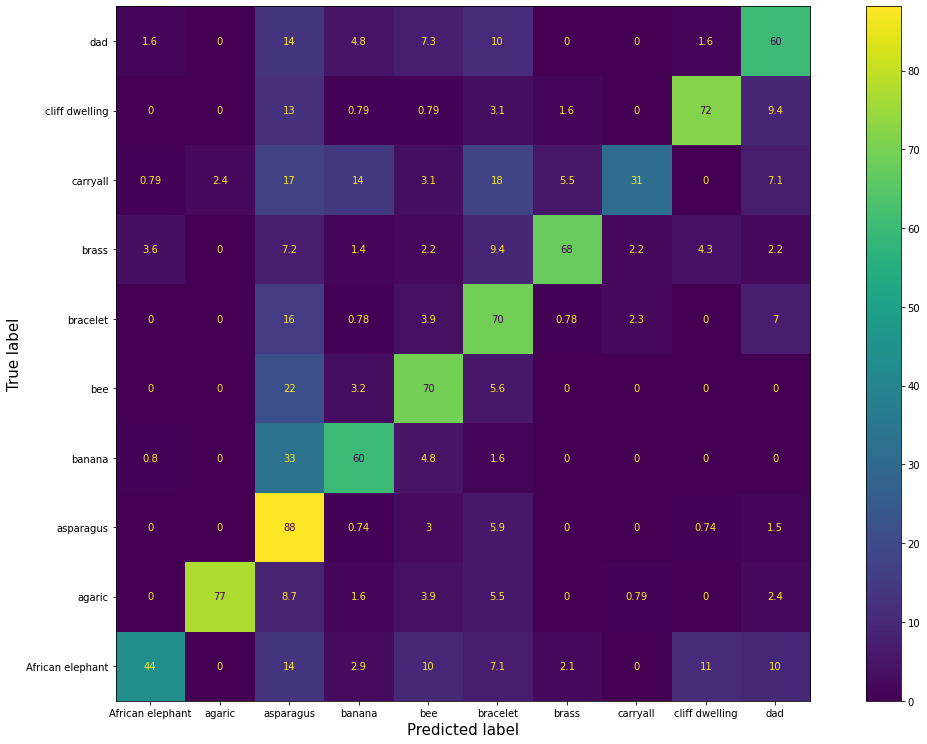

In [ ]:
#Generate Confusion Matrix for Dual-stream model

cm_dual_blur = confusion_matrix(true_outputs,dual_pred_outputs,normalize='true') * 100
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm_dual_blur,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
ax.invert_yaxis()

In [ ]:
print(classification_report(true_outputs,single_pred_outputs))
print(matthews_corrcoef(true_outputs, single_pred_outputs))

              precision    recall  f1-score   support

           0       0.65      0.56      0.60       140
           1       0.96      0.71      0.81       127
           2       0.39      0.84      0.53       135
           3       0.45      0.38      0.41       125
           4       0.46      0.71      0.56       125
           5       0.56      0.50      0.53       128
           6       0.88      0.38      0.53       139
           7       0.61      0.38      0.47       127
           8       0.65      0.33      0.44       127
           9       0.46      0.63      0.53       124

    accuracy                           0.54      1297
   macro avg       0.61      0.54      0.54      1297
weighted avg       0.61      0.54      0.54      1297

0.5005604646541421


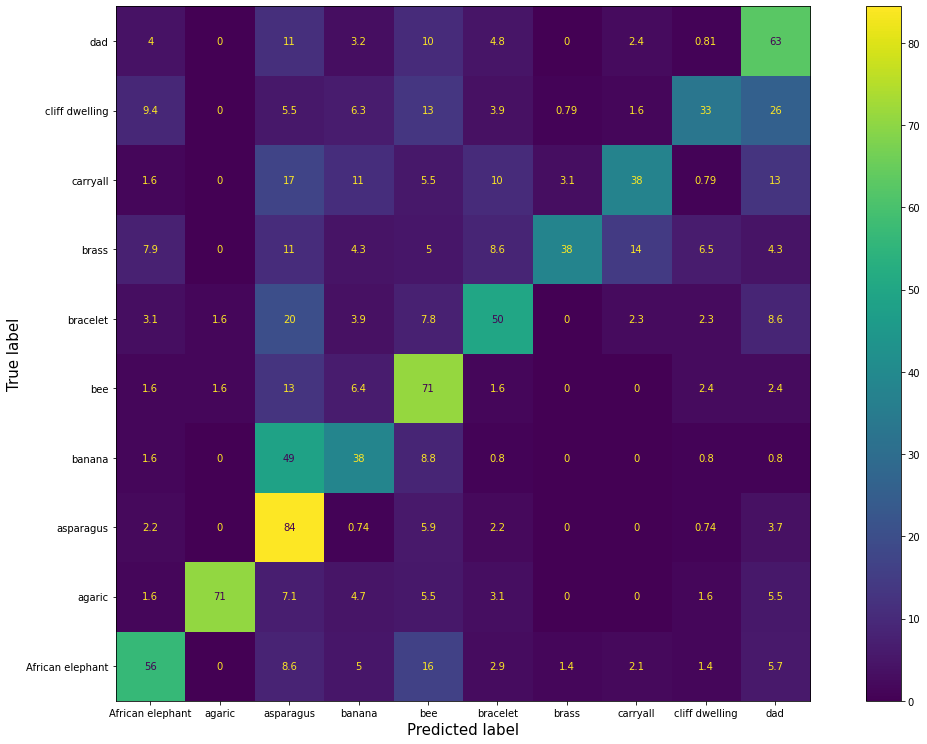

In [ ]:
#Generate Confusion Matrix for Single-stream ResNet

cm_single_blur = confusion_matrix(true_outputs,single_pred_outputs,normalize='true') * 100
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm_single_blur,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
ax.invert_yaxis()

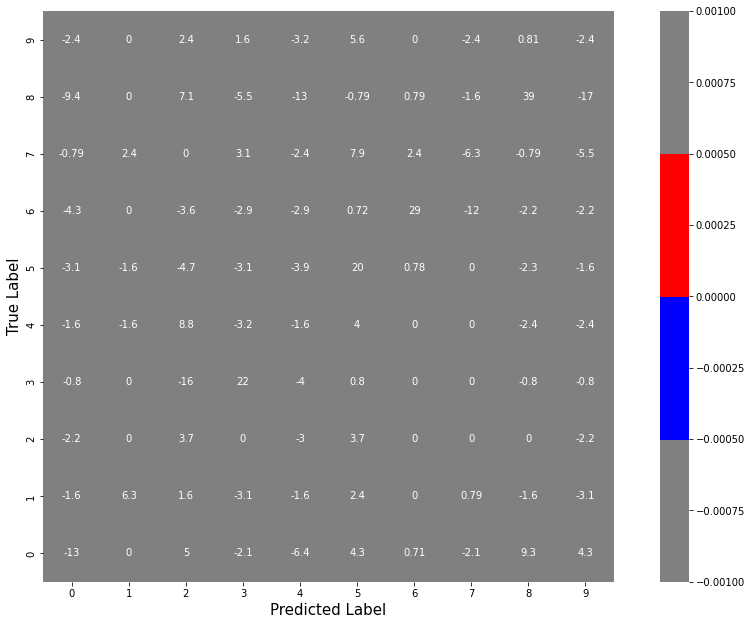

In [ ]:
cm_diff_blur = cm_dual_blur - cm_single_blur

B = confusion_matrix(true_outputs,single_pred_outputs)
n_trials = np.sum(B, axis=1)
p = confusion_matrix(true_outputs,single_pred_outputs, normalize='true')
m = np.copy(B)
C = np.zeros(shape=(10,10))
for row in range(10):
    n = n_trials[row]
    for col in range(10):
        dist = binom(n,p[row, col])
        if cm_diff_blur[row,col] >= 0:
            sign = 1
        else:
            sign = -1
        C[row,col] = dist.pmf(B[row,col]) * sign

cmap = colors.ListedColormap(["gray", "blue", "red", "gray"])
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-3, vmin=-1e-3, square=True, annot=cm_diff_blur, cmap=cmap)
#ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-1, vmin=-1e-1, annot=C, cmap='bwr')
#ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-1, vmin=-1e-1, annot=cm_diff_blur, cmap=cmap)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
ax.invert_yaxis()


### Testing the Occluded condition:

In [18]:
dual_test_loss, dual_test_accuracy = dual_stream_model.evaluate(test_ds_occluded)
single_test_loss, signle_test_accuracy = single_model.evaluate(test_ds_occluded)

41/41 [==============================] - 2s 56ms/step - loss: 4.4350 - accuracy: 0.2407


In [28]:
#Load Train and Test
dual_pred_outputs = dual_stream_model.predict(test_ds_occluded)
dual_pred_outputs = np.argmax(dual_pred_outputs,axis=1)

single_pred_outputs = single_model.predict(test_ds_occluded)
single_pred_outputs = np.argmax(single_pred_outputs,axis=1)

true_outputs = np.concatenate([labels for _,labels in test_ds_occluded])
true_outputs = np.argmax(true_outputs,axis=1)

In [29]:
print(classification_report(true_outputs,dual_pred_outputs))
print(matthews_corrcoef(true_outputs, dual_pred_outputs))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.76      0.32      0.45       127
           2       0.25      0.15      0.19       135
           3       0.87      0.10      0.19       125
           4       0.10      0.49      0.16       125
           5       0.17      0.57      0.26       128
           6       0.04      0.02      0.03       139
           7       0.00      0.00      0.00       127
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00       123

    accuracy                           0.16      1296
   macro avg       0.22      0.17      0.13      1296
weighted avg       0.21      0.16      0.13      1296

0.08542462573477518


C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


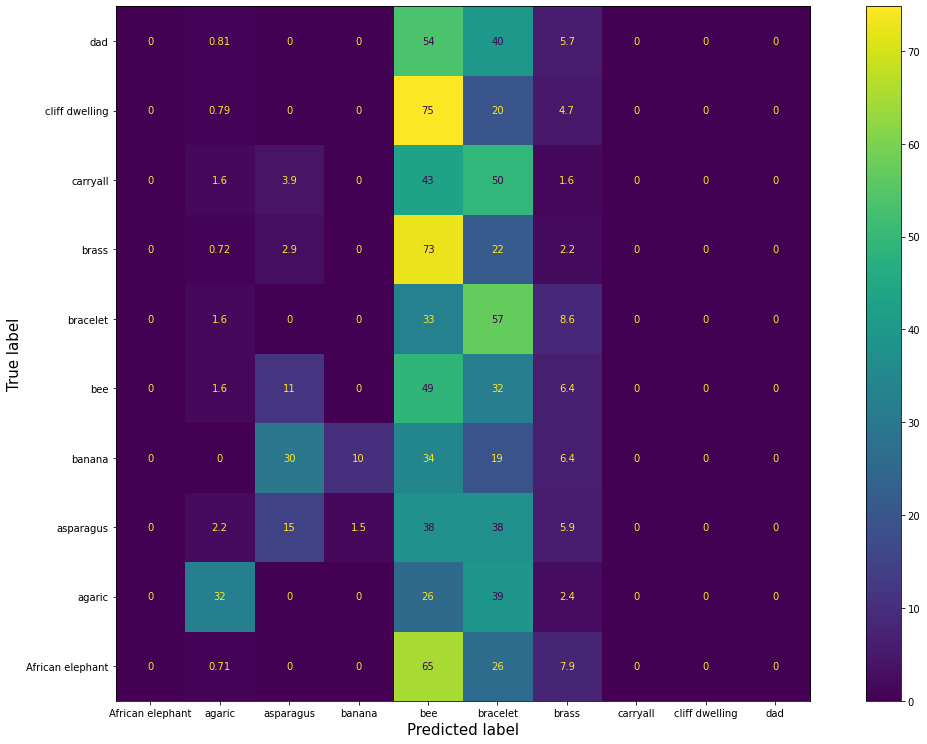

In [30]:
#Generate Confusion Matrix for Dual-stream model
A = confusion_matrix(true_outputs,dual_pred_outputs)
cm_dual_vanilla = confusion_matrix(true_outputs,dual_pred_outputs,normalize='true') * 100
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm_dual_vanilla,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
ax.invert_yaxis()

In [31]:
print(classification_report(true_outputs,single_pred_outputs))
print(matthews_corrcoef(true_outputs, single_pred_outputs))

              precision    recall  f1-score   support

           0       0.20      0.01      0.01       140
           1       0.42      0.54      0.47       127
           2       0.39      0.35      0.37       135
           3       0.60      0.24      0.34       125
           4       0.15      0.45      0.22       125
           5       0.14      0.55      0.23       128
           6       0.70      0.19      0.30       139
           7       0.25      0.10      0.15       127
           8       0.00      0.00      0.00       127
           9       0.00      0.00      0.00       123

    accuracy                           0.24      1296
   macro avg       0.29      0.24      0.21      1296
weighted avg       0.29      0.24      0.21      1296

0.17383399368284638


C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nelso\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


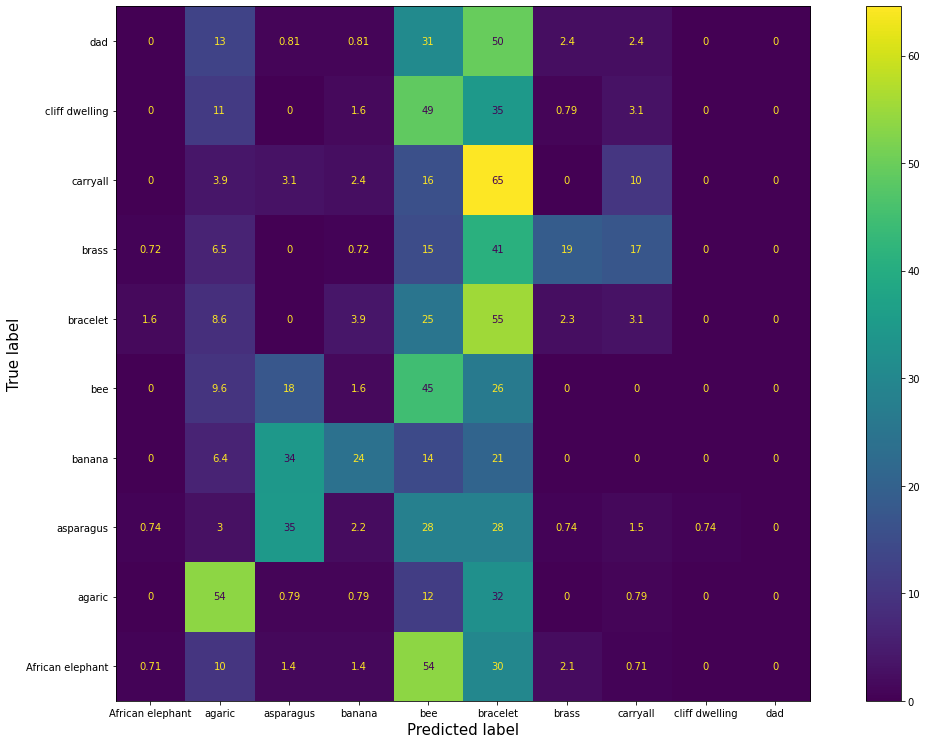

In [32]:
#Generate Confusion Matrix for Single-stream ResNet
cm_single_vanilla = confusion_matrix(true_outputs,single_pred_outputs, normalize='true') * 100
class_names = test_ds.class_names

disp_cm = ConfusionMatrixDisplay(cm_single_vanilla,display_labels=class_names)
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
ax.invert_yaxis()

'\ndisp_cm = ConfusionMatrixDisplay(cm_diff_vanilla,display_labels=class_names)\n\nax.set_xlabel("Predicted Label", fontsize = 15)\nax.set_ylabel("True Label", fontsize = 15)\n\nplt.tight_layout()\n\ndisp_cm.plot(ax=ax)\ndisp_cm.ax_.invert_yaxis()\n\nim = disp_cm.im_\n\n#plt.set_cmap(\'bwr\')'

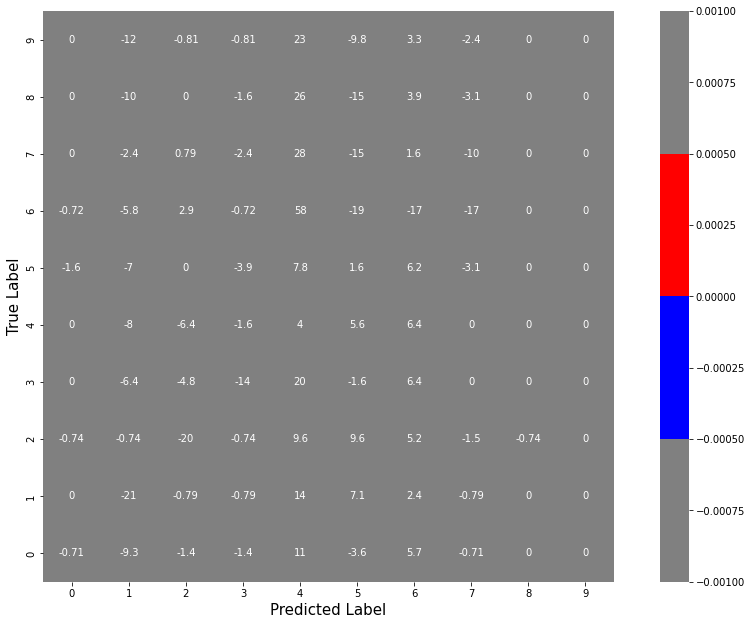

In [33]:
# Confusion Difference Matrix (Dual minus Single)

# Test if Single (B) is draw from a differnt distrbution that Dual (A)

cm_diff_vanilla = cm_dual_vanilla - cm_single_vanilla

B = confusion_matrix(true_outputs,single_pred_outputs)
n_trials = np.sum(B, axis=1)
p = confusion_matrix(true_outputs,single_pred_outputs, normalize='true')
m = np.copy(B)
C = np.zeros(shape=(10,10))
for row in range(10):
    n = n_trials[row]
    for col in range(10):
        dist = binom(n,p[row, col])
        if cm_diff_vanilla[row,col] >= 0:
            sign = 1
        else:
            sign = -1
        C[row,col] = dist.pmf(B[row,col]) * sign

cmap = colors.ListedColormap(["gray", "blue", "red", "gray"])
fig, ax = plt.subplots()
fig.set_size_inches(16.5, 10.5)
ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-3, vmin=-1e-3, square=True, annot=cm_diff_vanilla, cmap=cmap)
#ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-1, vmin=-1e-1, annot=cm_diff_vanilla, cmap='bwr')
#ax= sn.heatmap(C, ax=ax, center=0, vmax=1e-1, vmin=-1e-1, annot=cm_diff_vanilla, cmap=cmap)
ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)
ax.invert_yaxis()



'''
disp_cm = ConfusionMatrixDisplay(cm_diff_vanilla,display_labels=class_names)

ax.set_xlabel("Predicted Label", fontsize = 15)
ax.set_ylabel("True Label", fontsize = 15)

plt.tight_layout()

disp_cm.plot(ax=ax)
disp_cm.ax_.invert_yaxis()

im = disp_cm.im_

#plt.set_cmap('bwr')'''

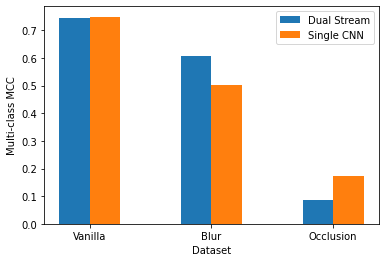

In [39]:
MCCs = np.array([[0.7460387968527745, 0.7491826868726083],
                [0.6077948055109794, 0.5005604646541421],
                [0.08542462573477518, 0.17383399368284638]])

fig, ax = plt.subplots()
x = np.arange(3)
ax.bar(x-.125, MCCs[:,0], width=.25, label='Dual Stream')
ax.bar(x+.125, MCCs[:,1], width=.25, label='Single CNN')
ax.set_xticks((0,1,2))
ax.set_xticklabels(('Vanilla', 'Blur','Occlusion'))
ax.set_xlabel('Dataset')
ax.set_ylabel('Multi-class MCC')
plt.legend()